 <!-- SVM, Small VGG Network, ArcFace, FCapNetwork -->

In [3]:
import os
import numpy as np
import cv2 
import json
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # Import the to_categorical function from Keras
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense # Import the Dropout class from Keras
from tensorflow.keras.models import Sequential
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator


dataset_path = "data"
image_size = (64*5, 48*5)

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


In [4]:
def load_json_data(json_file_path):
    with open(json_file_path, 'r') as jsonfile:
        return json.load(jsonfile)

def extract_segments(json_data):
    segments = {}
    for img in json_data:
        val = json_data[img]
        regions = val['regions']
        for region in regions:
            shape_attributes = region.get('shape_attributes', {})
            region_attributes = region.get('region_attributes', {})
            
            if region_attributes.get('Eye') == 'iris':
                x_points = shape_attributes.get('all_points_x', [])
                y_points = shape_attributes.get('all_points_y', [])
                segments[val['filename']] = list(zip(x_points, y_points))
    return segments

def traverse_data_folder(data_folder):
    all_segments = {}
    for root, _, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                json_data = load_json_data(json_file_path)
                segments = extract_segments(json_data)
                all_segments.update(segments)
    return all_segments

def generate_mask(image_shape, coordinates):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if coordinates:
        cv2.fillPoly(mask, [np.array(coordinates, dtype=np.int32)], 255)
    return mask

def apply_mask_to_image(image, mask):
    masked_image =  cv2.bitwise_and(image, image, mask=mask)
    if len(masked_image.shape) == 3 and masked_image.shape[2] == 3:
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    return masked_image


from IPython.display import clear_output

def get_segmented_images(images, names, segments):
    n_images = []
    shape = None
    for i in range(names.size):
        clear_output(wait=True)
        name = names[i]
        image = images[i]
        if (name not in segments):
            resized_img = cv2.resize(image, image_size)
            n_images.append(resized_img)
            continue
        segment = segments[name]
        print(image.shape)
        mask = generate_mask(image.shape, segment)
        masked_image = apply_mask_to_image(image, mask)
        resized_img = cv2.resize(masked_image, image_size)
        if shape == None:
            shape = resized_img.shape
        elif shape != resized_img.shape:
            print(shape)
            print(resized_img.shape)
            print(name)
            return
        n_images.append(resized_img)
        print(i)
    
    return n_images

def display_images(image, mask, masked_image, ffd="Image"):
    plt.figure(figsize=(15, 5))
    plt.title(ffd)
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image : " + ffd)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Iris Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title('Masked Image')
    plt.show()

def showImg(index):
    ffd = 'Alcoholic' if labels[index] else 'Fit for Duty'
    image = images[index]
    name = names[index]
    if (name not in segments):
        print("Segmentation not found for this image")
        return
    segment = segments[name]
    print(image.shape)
    mask = generate_mask(image.shape, segment)
    masked_image = apply_mask_to_image(image, mask)
    display_images(image, mask, masked_image, ffd)
    print(names[index])

Step 1: Loading DataSet

In [5]:
def load_images_from_folder(folder_path, max_depth = 5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    all_segments = {}

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue
        

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            # img = cv2.resize(img, image_size)
                            images.append(img)
                            labels.append(file[6]!='0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
                
                if file.endswith('.json'):
                    json_file_path = os.path.join(root, file)
                    json_data = load_json_data(json_file_path)
                    segments = extract_segments(json_data)
                    all_segments.update(segments)

        else:
            del dirs[:]
    
    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")

    return np.array(images), np.array(labels), np.array(names), all_segments

images, labels, names, segments = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 480, 640)


Randome index: 871
(480, 640)


/var/folders/_n/hy51y1yj2vs255rlfs0k3g1r0000gn/T/ipykernel_62020/3545928963.py:77: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


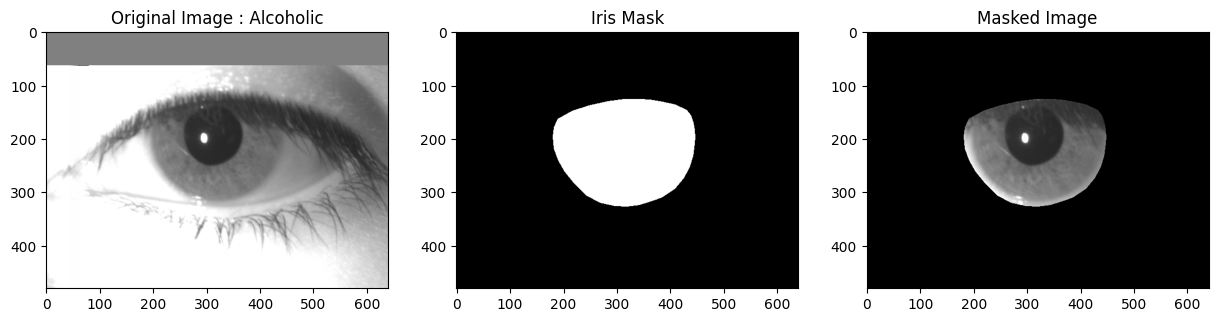

E_4_2_4_L_M_N_N_1996_5_2017.bmp


In [6]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
showImg(ri)

In [7]:
images = get_segmented_images(images, names, segments)

(480, 640)
2819


In [8]:
images = np.array(images)

Randome index: 478


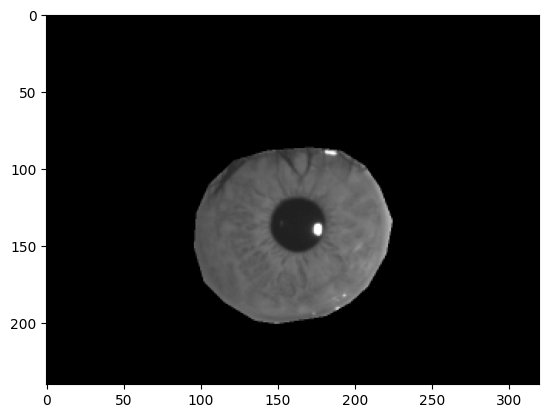

In [9]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
plt.imshow(images[ri], cmap='gray')

In [10]:
images.shape

(2820, 240, 320)

In [11]:
#Removing Bias towards Alcohol Detection

#Splitting Classes
alcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 0]

alcoholicClass = np.array(alcoholicClass)
nonAlcoholicClass = np.array(nonAlcoholicClass)

#Data Generator Setup
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.025,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Augmentation:

n1 = len(nonAlcoholicClass)
n2 = len(alcoholicClass)
target_size = n2
augmentation_needed = target_size - n1

print(f'Number of samples in Class 1 (FFD): {n1}')
print(f'Number of samples in Class 2 (Alcoholic): {n2}')
print(f'Augmenting {augmentation_needed} images for Class 1 to match Class 2.')

augmented_images = []
for i in range(augmentation_needed):
    img = nonAlcoholicClass[i % n1]  
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)  
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_img = np.squeeze(augmented_img, axis=-1)
    augmented_img = augmented_img.astype(int)
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)

concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)
concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)

print(f'New size of Class 1: {len(alcoholicClass)}')
print(f'New size of Class 2: {len(concagtedClassNon)}')

Number of samples in Class 1 (FFD): 580
Number of samples in Class 2 (Alcoholic): 2240
Augmenting 1660 images for Class 1 to match Class 2.
New size of Class 1: 2240
New size of Class 2: 2240


In [12]:
alcoholic_labels = np.ones(len(alcoholicClass))
nonAlcoholic_labels = np.zeros(len(concagtedClassNon))

images = np.concatenate([alcoholicClass, concagtedClassNon], axis=0)
labels = np.concatenate([alcoholic_labels, nonAlcoholic_labels], axis=0)

shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
labels = labels[shuffled_indices]

print(f"Total number of images after augmentation: {len(images)}")
print(f"Shape of final images array: {images.shape}")
print(f"Shape of final labels array: {labels.shape}")

Total number of images after augmentation: 4480
Shape of final images array: (4480, 240, 320)
Shape of final labels array: (4480,)


In [13]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=20)

labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

In [14]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=image_size+(1,)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
print(len(images_train))
print(len(labels_train_cnn))
print(images_train[0].shape)

3584
3584
(240, 320)


In [16]:
cnn_model.fit(images_train, labels_train_cnn, epochs=10, batch_size=32)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.6372 - loss: 47.5245
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 298ms/step - accuracy: 0.8121 - loss: 0.4646
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 310ms/step - accuracy: 0.8436 - loss: 0.3714
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 33s 297ms/step - accuracy: 0.8852 - loss: 0.3040
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 336ms/step - accuracy: 0.9149 - loss: 0.2226
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.9227 - loss: 0.1976
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 359ms/step - accuracy: 0.9336 - loss: 0.1797
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.9446 - loss: 0.1363
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - accuracy: 0.9515 - loss: 0.1233
Epoch 10/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 339ms/step - accuracy: 0.9586 - loss: 0.1052


In [18]:
#Testing model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8120 - loss: 0.5757
CNN Test Accuracy: 82.25%


In [19]:
from sklearn.metrics import classification_report, accuracy_score

predictions = cnn_model.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

print(images_test.shape)


report = classification_report(true_classes, predicted_classes, target_names=['FFD', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
(896, 240, 320)
              precision    recall  f1-score   support

         FFD       0.85      0.79      0.82       449
   Alcoholic       0.80      0.86      0.83       447

    accuracy                           0.82       896
   macro avg       0.82      0.82      0.82       896
weighted avg       0.82      0.82      0.82       896

Overall Accuracy: 82.25%


Demonstration

In [20]:
totalTest = 0
correctTest = 0

(1, 240, 320)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Text(0.5, 1.0, 'Name: E_3_1_1_R_M_N_N_1974_2_2017.bmp\n\nPrediction: Alcoholic\nActual: Alcoholic\n\nAccuracy: 1.0')

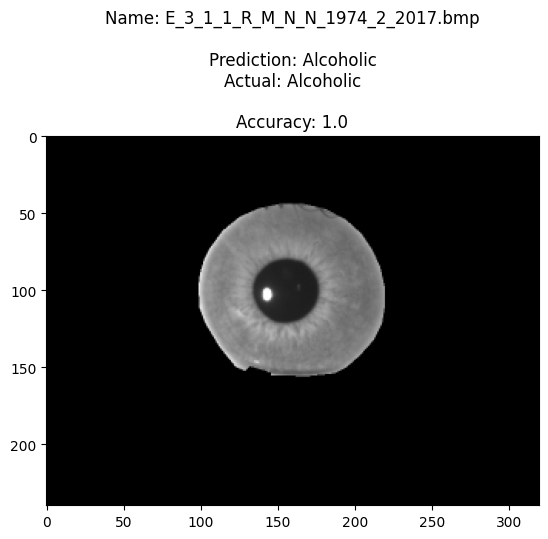

In [25]:
# testImagePath = 'images/test2.png'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)

testImg = images[r_in]
testLabel = labels[r_in]
testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')

In [ ]:
#Exporting the model
modelName = "SegmentedDatasetModel"
dirt = f"Models/{modelName}"
if not os.path.exists(dirt):
    os.makedirs(dirt)
cnn_model.save(f"{dirt}/{modelName}.h5")

NameError: name 'os' is not defined